In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence

from sklearn.preprocessing import LabelEncoder

from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import confusion_matrix, recall_score

from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold, GridSearchCV

from time import time
from datetime import datetime
import statistics 

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend.


In [2]:
car_review = pd.read_csv('car_review.csv', index_col=0)

In [3]:
car_review.head()

,Rating,Year,Review,Brand
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/


In [4]:
car_review.Rating.value_counts()

5    14704
4     3211
3      730
2      313
1      284
Name: Rating, dtype: int64

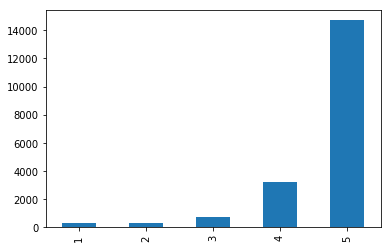

In [5]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

* Reviews are skewed towards positive

# Cleaning data and rettive features

### Car

In [6]:
car_review['Car'] = car_review.Brand.map(lambda x: x.split('/')[0])
car_review['Car_Year'] = car_review['Car'].map(lambda x: x.split('-')[-1])
car_review['Car_test'] = car_review['Car'].map(lambda x: x.split('-')[:-1])
car_review['Car_Make'] = car_review['Car_test'].map(lambda x: x[0])
car_review['Car_Model'] = car_review['Car_test'].map(lambda x: x[-1])

In [7]:
car_review.drop(['Car_test'], axis=1, inplace=True)

In [8]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model
1,4,\n by JayeMaye\n ...,\n This is what I've bought Sat...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
2,5,\n by Female Driver\n ...,\n I just got my Special Order ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
3,5,\n by New Car Buyer\n ...,\n About 2 months ago I purchas...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
4,5,\n by KTisaPhillyPhan\n ...,\n We bought a tungsten metalli...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger
5,5,\n by I<3DODGE\n ...,\n I have a 2012 Dodge Charger ...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger


### Reviews

In [9]:
car_review['Review'] = car_review['Review'].map(lambda x: x.rstrip().lstrip())

In [10]:
car_review['Review'].head()

1    This is what I've bought Saturday:\n2012 Dodge...
2    I just got my Special Order wiith my name on w...
3    About 2 months ago I purchased a new Dodge Cha...
4    We bought a tungsten metallic SXT-Plus Charger...
5    I have a 2012 Dodge Charger R/T Plus AWD in re...
Name: Review, dtype: object

### Date

In [11]:
car_review['Review_Date'] = car_review['Year'].map(lambda x: 
                                                   datetime.strptime(x.split('\n')[-2].split('on')[-1].lstrip(), '%B %d, %Y'))
car_review['Review_Year'] = car_review['Review_Date'].map(lambda x: x.year)
car_review['Review_Month'] = car_review['Review_Date'].map(lambda x: x.month)
car_review['Review_Day'] = car_review['Review_Date'].map(lambda x: x.day)

In [12]:
car_review[['Review_Date', 'Review_Year', 'Review_Month', 'Review_Day']].head()

,Review_Date,Review_Year,Review_Month,Review_Day
1,2012-05-02,2012,5,2
2,2012-06-14,2012,6,14
3,2012-06-29,2012,6,29
4,2012-05-08,2012,5,8
5,2012-03-19,2012,3,19


### Car Age

In [13]:
int(car_review['Car_Year'][1])

2012

In [14]:
car_review['Car_Age'] = car_review['Review_Year'].map(lambda x: int(x))-car_review['Car_Year'].map(lambda x: int(x))

In [15]:
car_review['Car_Age'] = car_review['Car_Age'].map(lambda x: 0 if x==-1 else x)

In [16]:
# plt.hist(car_review['Car_Age'], bins='auto')

### Remove duplicate review
* There are some duplicate reviews in the dataset

In [17]:
car_review.shape

(19242, 13)

In [18]:
car_review.Review.nunique()

10821

In [19]:
car_review.Review.value_counts().head(5)

A solid compact sedan. I owned a Civic years ago, and I like the emergency brake redesign. The gas cap is gone, and the lid over the gas fill intake locks when the doors lock, and unlocks when the doors unlock. This makes a lot of sense.    52
I am very happy with my purchase. No buyers remorse at all. Fast, fun, reliable and comfortable! Would highly recommend this car to anyone. You will not find more bang for you buck.                                                            52
Excellent car. Excellent performance and very stylish. Handles excellent on the road. When you need the power this car has it with no problem.                                                                                                   50
This is my first new car and I am happy with the comfort and look of the car.  The Civic Hatchback is great to handle and the technical aspects of the car are easy to understand.                                                               50
This car is great for yo

In [20]:
car_review=car_review.drop_duplicates(subset=['Review'])

In [21]:
print('Number of unique reviews: ', car_review.Review.nunique())
print('Shape of the dataset: ', car_review.shape)

Number of unique reviews:  10821
Shape of the dataset:  (10821, 13)


In [22]:
car_review.head()

,Rating,Year,Review,Brand,Car,Car_Year,Car_Make,Car_Model,Review_Date,Review_Year,Review_Month,Review_Day,Car_Age
1,4,\n by JayeMaye\n ...,This is what I've bought Saturday:\n2012 Dodge...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-05-02,2012,5,2,0
2,5,\n by Female Driver\n ...,I just got my Special Order wiith my name on w...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-06-14,2012,6,14,0
3,5,\n by New Car Buyer\n ...,About 2 months ago I purchased a new Dodge Cha...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-06-29,2012,6,29,0
4,5,\n by KTisaPhillyPhan\n ...,We bought a tungsten metallic SXT-Plus Charger...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-05-08,2012,5,8,0
5,5,\n by I<3DODGE\n ...,I have a 2012 Dodge Charger R/T Plus AWD in re...,dodge-charger-2012/consumer-reviews/,dodge-charger-2012,2012,dodge,charger,2012-03-19,2012,3,19,0


In [23]:
car_review.Rating.value_counts()

5    7815
4    1943
3     538
2     273
1     252
Name: Rating, dtype: int64

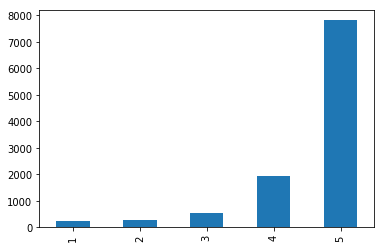

In [24]:
car_review.Rating.value_counts(sort=False).plot(kind = 'bar')
plt.show()

# Visualization

max:  4076
min:  48
average:  396.6112189261621
median:  237
Standard Deviation: 442.9049


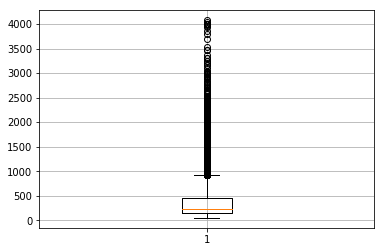

In [25]:
l=[len(i) for i in car_review.Review]
print('max: ',max(l))
print('min: ',min(l))
print('average: ',sum(l)/len(l))
print('median: ', statistics.median(l))
print('Standard Deviation: {:.4f}'.format(np.std(l)))
plt.boxplot(l)
plt.grid(True)

In [26]:
396.6112189261621+442.9049

839.5161189261621

In [27]:
396.6112189261621+442.9049*2

1282.421018926162

# Split the data set

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
car_review['tag'] = car_review['Rating'].map(lambda x:0 if x==5 else 1)
car_review['tag'].value_counts(sort=False)

0    7815
1    3006
Name: tag, dtype: int64

In [30]:
x = car_review.Review
y = car_review.tag

In [32]:
Xtrain, Xtest, ytrain, ytest = train_test_split(x, y, random_state=10, test_size=0.2)

# Neural Network

In [110]:
#Create a validation just for convenience
def model(trainy,pre_trainy, testy, pre_testy):  
    pre_trainy2 = [0 if i <0.5 else 1 for i in pre_trainy.reshape(len(pre_trainy),)]
    fpr_train, tpr_train,_=roc_curve(trainy, pre_trainy2)
    auc_train=auc(fpr_train, tpr_train)
    
    pre_testy2 = [0 if i <0.5 else 1 for i in pre_testy.reshape(len(pre_testy),)]
    fpr_test, tpr_test,_=roc_curve(testy, pre_testy2)
    auc_test=auc(fpr_test, tpr_test)
    
    print('AUC(Train): {:.4f}'.format(auc_train))
    print('AUC(Test):  {:.4f}'.format(auc_test))
    print ("TRAIN Accuracy:   %0.3f" % accuracy_score(trainy, trainy, pre_trainy2))
    print ("TEST Accuracy:   %0.3f" % accuracy_score(testy, pre_testy2))
    
    cm = confusion_matrix(testy, pre_testy2, labels = [0, 1])
    print('Confusion matrix, without normalization:')
    print(cm)
    print("Normalized confusion matrix:")
    print(cm.astype('float') / cm.sum(axis=1)[:, np.newaxis])
    print(classification_report(testy, pre_testy2))

## Process the data:
* Tokenize the data and convert the text to sequence;
* Add padding to ensure that all the sequences have the same shape/length.

In [55]:
max_words = 20000
max_len = 400
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(Xtrain)

sequences = tok.texts_to_sequences(Xtrain)
train_sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

test_sequences = tok.texts_to_sequences(Xtest)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

# 1. LSTM

In [63]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Dense, Embedding, Dropout, LSTM, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.models import Sequential

In [57]:
lstm = Sequential()
lstm.add(Embedding(max_words,128,input_length=max_len))

lstm.add(Dropout(0.2))
lstm.add(LSTM(100))
lstm.add(Dropout(0.2))

lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(lstm.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 400, 128)          2560000   
_________________________________________________________________
dropout_6 (Dropout)          (None, 400, 128)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               91600     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 101       
Total params: 2,651,701
Trainable params: 2,651,701
Non-trainable params: 0
_________________________________________________________________
None


In [58]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [59]:
start_time_lstm=time()
lstm_history = lstm.fit(train_sequences_matrix, ytrain, 
          nb_epoch=10, batch_size=64,
          validation_split=0.2,
       callbacks=callback)
end_time_lstm=time()
print(end_time_lstm-start_time_lstm)

Train on 6924 samples, validate on 1732 samples
Epoch 1/10
6924/6924 [==============================] - 171s 25ms/step - loss: 0.5527 - acc: 0.7314 - val_loss: 0.4834 - val_acc: 0.7662
Epoch 2/10
6924/6924 [==============================] - 174s 25ms/step - loss: 0.4128 - acc: 0.8232 - val_loss: 0.4740 - val_acc: 0.7875
Epoch 3/10
6924/6924 [==============================] - 174s 25ms/step - loss: 0.3249 - acc: 0.8710 - val_loss: 0.5329 - val_acc: 0.7685
Epoch 4/10
6924/6924 [==============================] - 169s 24ms/step - loss: 0.2475 - acc: 0.9051 - val_loss: 0.5670 - val_acc: 0.7471
688.9480068683624


In [60]:
pre_lstm_train=lstm.predict(train_sequences_matrix)
pre_lstm_test=lstm.predict(test_sequences_matrix)
lstm.save('lstm-model.h5')

In [61]:
lstm_scores = lstm.evaluate(test_sequences_matrix, ytest)

2165/2165 [==============================] - 11s 5ms/step


In [62]:
print('loss     = ', lstm_scores[0])
print('accuracy = ', lstm_scores[1])

loss     =  0.527327587560473
accuracy =  0.7861431872872227


In [109]:
model(ytrain,pre_lstm_train, ytest, pre_lstm_test)

AUC(Train): 0.8612
AUC(Test):  0.6859
TRAIN Accuracy:   1.000
TEST Accuracy:   0.786
Confusion matrix, without normalization:
[[1429  154]
 [ 309  273]]
Normalized confusion matrix:
[[0.90271636 0.09728364]
 [0.53092784 0.46907216]]
             precision    recall  f1-score   support

          0       0.82      0.90      0.86      1583
          1       0.64      0.47      0.54       582

avg / total       0.77      0.79      0.77      2165



# 2. CNN

In [88]:
cnn = Sequential()
cnn.add(Embedding(max_words,128,input_length=max_len))

cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
cnn.add(MaxPooling1D(pool_size=2))

cnn.add(Flatten())

cnn.add(Dense(250, activation='relu'))

cnn.add(Dense(1, activation='sigmoid'))
cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

print(cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 400, 128)          2560000   
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 400, 32)           12320     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6400)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 250)               1600250   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 251       
Total params: 4,172,821
Trainable params: 4,172,821
Non-trainable params: 0
_________________________________________________________________


In [89]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [90]:
start_time_cnn=time()
cnn_history = cnn.fit(train_sequences_matrix, ytrain, 
          nb_epoch=10, batch_size=64,
          validation_split=0.2,
       callbacks=callback)
end_time_cnn=time()
print(end_time_cnn-start_time_cnn)

Train on 6924 samples, validate on 1732 samples
Epoch 1/10
6924/6924 [==============================] - 21s 3ms/step - loss: 0.5570 - acc: 0.7304 - val_loss: 0.4820 - val_acc: 0.7783
Epoch 2/10
6924/6924 [==============================] - 22s 3ms/step - loss: 0.3586 - acc: 0.8494 - val_loss: 0.4899 - val_acc: 0.7818
Epoch 3/10
6924/6924 [==============================] - 19s 3ms/step - loss: 0.1537 - acc: 0.9463 - val_loss: 0.6367 - val_acc: 0.7523
62.05176305770874


In [91]:
pre_cnn_train=cnn.predict(train_sequences_matrix)
pre_cnn_test=cnn.predict(test_sequences_matrix)
cnn.save('cnn-model.h5')

In [92]:
cnn_scores = cnn.evaluate(test_sequences_matrix, ytest)
print('loss     = ', cnn_scores[0])
print('accuracy = ', cnn_scores[1])

2165/2165 [==============================] - 1s 661us/step
loss     =  0.6125125522701624
accuracy =  0.75612009257147


In [93]:
model(ytrain,pre_cnn_train, ytest, pre_cnn_test)

AUC(Train): 0.9323
AUC(Test):  0.7034
TRAIN Accuracy:   1.000
TEST Accuracy:   0.756
Confusion matrix, without normalization:
[[1294  289]
 [ 239  343]]
Normalized confusion matrix:
[[0.81743525 0.18256475]
 [0.41065292 0.58934708]]
             precision    recall  f1-score   support

          0       0.84      0.82      0.83      1583
          1       0.54      0.59      0.57       582

avg / total       0.76      0.76      0.76      2165



# 3.LSTM+CNN

In [94]:
lstm_cnn = Sequential()
lstm_cnn.add(Embedding(max_words,128,input_length=max_len))

lstm_cnn.add(Dropout(0.2))
lstm_cnn.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
lstm_cnn.add(MaxPooling1D(pool_size=2))
lstm_cnn.add(LSTM(100))
lstm_cnn.add(Dropout(0.2))

lstm_cnn.add(Dense(1, activation='sigmoid'))
lstm_cnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(lstm_cnn.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 400, 128)          2560000   
_________________________________________________________________
dropout_8 (Dropout)          (None, 400, 128)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 400, 32)           12320     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 200, 32)           0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_9 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total para

In [95]:
callback=[
    EarlyStopping(monitor='val_loss', patience=2),
    ModelCheckpoint(filepath='weights.{epoch:02d}-{val_acc:.2f}.hdf5',save_best_only=True)
]

In [96]:
start_time_lstm_cnn=time()
lstm_cnn_history = lstm_cnn.fit(train_sequences_matrix, ytrain, 
          nb_epoch=10, batch_size=64,
          validation_split=0.2,
       callbacks=callback)
end_time_lstm_cnn=time()
print(end_time_lstm_cnn-start_time_lstm_cnn)

Train on 6924 samples, validate on 1732 samples
Epoch 1/10
6924/6924 [==============================] - 84s 12ms/step - loss: 0.5648 - acc: 0.7215 - val_loss: 0.5168 - val_acc: 0.7535
Epoch 2/10
6924/6924 [==============================] - 86s 12ms/step - loss: 0.4323 - acc: 0.8122 - val_loss: 0.4767 - val_acc: 0.7852
Epoch 3/10
6924/6924 [==============================] - 87s 13ms/step - loss: 0.3193 - acc: 0.8696 - val_loss: 0.5569 - val_acc: 0.7592
Epoch 4/10
6924/6924 [==============================] - 89s 13ms/step - loss: 0.2398 - acc: 0.9086 - val_loss: 0.6095 - val_acc: 0.7211
348.12667870521545


In [100]:
pre_lstm_cnn_train=lstm_cnn.predict(train_sequences_matrix)
pre_lstm_cnn_test=lstm_cnn.predict(test_sequences_matrix)
lstm_cnn.save('lstm_cnn-model.h5')

In [101]:
lstm_cnn_scores = lstm_cnn.evaluate(test_sequences_matrix, ytest)
print('loss     = ', lstm_cnn_scores[0])
print('accuracy = ', lstm_cnn_scores[1])

2165/2165 [==============================] - 6s 3ms/step
loss     =  0.5735552474477825
accuracy =  0.7487297923955851


In [102]:
model(ytrain, pre_lstm_cnn_train, ytest, pre_lstm_cnn_test)

AUC(Train): 0.8785
AUC(Test):  0.6804
TRAIN Accuracy:   1.000
TEST Accuracy:   0.749
Confusion matrix, without normalization:
[[1311  272]
 [ 272  310]]
Normalized confusion matrix:
[[0.82817435 0.17182565]
 [0.46735395 0.53264605]]
             precision    recall  f1-score   support

          0       0.83      0.83      0.83      1583
          1       0.53      0.53      0.53       582

avg / total       0.75      0.75      0.75      2165

